<h1> Binary classification </h1>

<hr>

<p> 
The present project intends to build a network to classify Reuters newswires into 46 mutually exclusive topics. 
</p>

<h2> The Dataset </h2>

<hr>

<p> The Reuters dataset, a set of short newswires and their topics, published by Reuters in 1986. It’s a simple, widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set. </p>
<p> This dataset comes packaged with Keras. </p>


In [1]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)

2110848/2110848 [==============================] - 0s 0us/step


<p> We will only keep the top 10,000 most frequently occurring words in the training data. Rare words will be discarded. This allows you to work with vector data of manageable size. </p>

In [2]:
len(train_data)

8982

In [3]:
len(test_data)

2246

In [4]:
train_data[1]

[1,
 3267,
 699,
 3434,
 2295,
 56,
 2,
 7511,
 9,
 56,
 3906,
 1073,
 81,
 5,
 1198,
 57,
 366,
 737,
 132,
 20,
 4093,
 7,
 2,
 49,
 2295,
 2,
 1037,
 3267,
 699,
 3434,
 8,
 7,
 10,
 241,
 16,
 855,
 129,
 231,
 783,
 5,
 4,
 587,
 2295,
 2,
 2,
 775,
 7,
 48,
 34,
 191,
 44,
 35,
 1795,
 505,
 17,
 12]

In [5]:
# word_index is a dictionary mapping words to an integer index.
word_index = reuters.get_word_index()

# Reverses it, mapping integer indices to words
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()]
)
[reverse_word_index.get(word, '?') for word in train_data[10]]
# The indices are offset by 3 because 0, 1, and 2 are reserved indices for “padding,” “start of sequence,” and “unknown"
decoded_review = ' '.join(
    [reverse_word_index.get(i - 3, '?') for i in train_data[0]]
)

550378/550378 [==============================] - 0s 0us/step


In [6]:
decoded_review

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

<h2> Preparing the Data </h2>

<hr>

<p> You can’t feed lists of integers into a neural network. You have to turn your lists into tensors. </p>
<p> For that we will pad our lists so that they all have the same length, turn them into an integer tensor of shape (samples, word_indices), and then use as the first layer in your network a layer capable of handling such integer tensors. </p>

In [7]:
from tensorflow.keras.utils import pad_sequences

In [8]:
[len(sentences) for sentences in train_data[:10]]

[87, 56, 139, 224, 101, 116, 100, 100, 82, 106]

In [9]:
train_padded = pad_sequences(train_data, padding='post', maxlen=100)
test_padded = pad_sequences(test_data, padding='post', maxlen=100)

In [10]:
[len(sequence) for sequence in train_padded[:20]]

[100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100]

In [16]:
[sentences for sentences in train_labels[:10]]

[3, 4, 3, 4, 4, 4, 4, 3, 3, 16]

In [17]:
type(train_labels)

numpy.ndarray

In [ ]:
import numpy as np

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [ ]:
y_train.shape

(8982,)

<h2> Building your network </h2>

<hr>

<p> A low-dimensional space may be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks, permanently dropping relevant information. </p>
<p> Therefor, we are going to use layers with 64 units. </p>
<p> The end of the network is constituted with a Dense layer of size 46. This means for each input sample, the network will output a 46-dimensional vector. Each entry in this vector (each dimension) will encode a different output class. </p>
<p> The last layer uses a softmax activation. It means the network will output a probability distribution over the 46 different output classes—for every input sample, the network will produce a 46-dimensional output vector, where output is the probability that the sample belongs to class i. The 46 scores will sum to 1. </p>
<p> The loss function: <pre> categorical_crossentropy </pre> 
Expects the labels to follow a categorical encoding. With integer labels, it is necessary to use: <pre> sparse_categorical_ crossentropy </pre> </p>

In [18]:
from tensorflow.keras import Sequential, layers

In [35]:
vocab_size = 10000
embedding_dim = 64
max_length = 100

model = Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(46, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 64)           640000    
                                                                 
 global_average_pooling1d_4   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 46)                2990      
                                                                 
Total params: 651,310
Trainable params: 651,310
Non-trainable params: 0
________________________________________________

<h2> Validating </h2>

<hr>

In [25]:
x_val = train_padded[:1000]
partial_x_train = train_padded[1000:]

y_val = train_labels[:1000]
partial_y_train = train_labels[1000:]

In [26]:
print("------------------------------------\n"+
      "Validation Data: " + str(x_val.shape) + "\n"+
      "Train Data: " + str(partial_x_train.shape) + "\n"
      "------------------------------------")

------------------------------------
Validation Data: (1000, 100)
Train Data: (7982, 100)
------------------------------------


<h2> Training your model </h2>

<hr>

<p> The model is trained for 20 epochs (20 iterations over all samples in the x_train and y_train tensors), in mini-batches of 512 samples. At the same time, the loss and accuracy are monitored on the 10,000 samples that you set apart. This is done by passing the validation data as the validation_data argument. </p>

In [36]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 9s 187ms/step - loss: 3.7764 - accuracy: 0.3499 - val_loss: 3.6785 - val_accuracy: 0.4590
Epoch 2/20
16/16 [==============================] - 3s 176ms/step - loss: 3.4828 - accuracy: 0.4503 - val_loss: 3.1255 - val_accuracy: 0.4480
Epoch 3/20
16/16 [==============================] - 3s 193ms/step - loss: 2.6775 - accuracy: 0.4033 - val_loss: 2.2769 - val_accuracy: 0.3540
Epoch 4/20
16/16 [==============================] - 3s 188ms/step - loss: 2.2482 - accuracy: 0.3548 - val_loss: 2.1357 - val_accuracy: 0.4040
Epoch 5/20
16/16 [==============================] - 2s 138ms/step - loss: 2.1033 - accuracy: 0.4307 - val_loss: 2.0303 - val_accuracy: 0.4500
Epoch 6/20
16/16 [==============================] - 2s 126ms/step - loss: 2.0013 - accuracy: 0.4526 - val_loss: 1.9399 - val_accuracy: 0.4760
Epoch 7/20
16/16 [==============================] - 2s 139ms/step - loss: 1.9135 - accuracy: 0.4778 - val_loss: 1.8655 - val_accuracy: 0.4960
Epoch 

<p> The call to model.fit() returns a History object. This object has a member history, which is a dictionary containing data about everything that happened during training. </p>

In [37]:
history_dict = history.history

In [38]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

<h2> Plotting the training and validation loss </h2>

<hr>



In [39]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

In [40]:
epochs = range(1, len(acc) + 1)
epochs

range(1, 21)

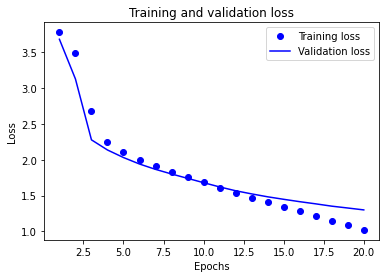

In [41]:
import matplotlib.pyplot as plt

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

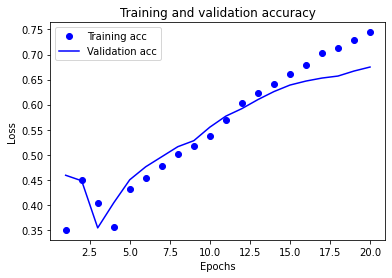

In [42]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<h2> Generate predictions on new data </h2>

<hr>

<p> It is possible to generate the likelihood of reviews being positive by using the predict method. </p>

In [43]:
test_padded = pad_sequences(test_data, padding='post', maxlen=100)

In [44]:
test_padded.shape

(2246, 100)

In [46]:
predictions = model.predict(test_padded)

71/71 [==============================] - 0s 4ms/step


<p> Each entry in predictions is a vector of length 46. </p>

In [48]:
predictions[0].shape

(46,)

<p> The coefficients in this vector sum to 1. </p>

In [50]:
import numpy as np

np.sum(predictions[0])

1.0

<p> The largest entry is the predicted class—the class with the highest probability. </p>

In [51]:
np.argmax(predictions[0])

3

<hr>